In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob
import arviz as az

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os
from ESB_functions import *
sns.set_context("paper")

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
#path_to_SPIRE=['/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]
#redshift_file=["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]

In [3]:
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')

In [466]:
source=[1]

In [467]:
model = 'model2'

try:
    data=az.InferenceData.from_netcdf('./output/{}/posterior_{}_{}_{}.nc'.format(field[0],field[0],source[0],model))
    prior_list=Table.read('./output/{}/prior_list_{}_{}_{}.ascii'.format(field[0],field[0],source[0],model),format='ascii',encoding='utf-8')
    priors,_ = xidplus.load('./output/{}/prior_{}_{}_{}.pkl'.format(field[0],field[0],source[0],model))
except FileNotFoundError:
    model = 'model1'
    data=az.InferenceData.from_netcdf('./output/{}/posterior_{}_{}_{}.nc'.format(field[0],field[0],source[0],model))
    prior_list=Table.read('./output/{}/prior_list_{}_{}_{}.ascii'.format(field[0],field[0],source[0],model),format='ascii',encoding='utf-8')
    priors,_ = xidplus.load('./output/{}/prior_{}_{}_{}.pkl'.format(field[0],field[0],source[0],model))


In [468]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [469]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=c.separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J104201.994+584018.387
HELP_J104201.199+584021.132
HELP_J104201.658+584011.825
HELP_J104200.887+584011.215
HELP_J104201.712+584006.945
HELP_J104202.499+584025.262 
 are possible contributers to flux of extreme starburst


In [470]:
ind = prior_list['help_id']==priors[0].ID[np.argmin(separation)]


In [471]:
prior_list['help_id'][ind]

HELP_J104201.994+584018.387


In [472]:
import jax.numpy as jnp
emulator_path=['/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']


def create_phys_prior(priors,prior_list,emulator_path):
    z_mu=np.empty((priors[1].nsrc))
    z_sig=np.empty((priors[1].nsrc))

    for x,i in enumerate(priors[1].ID):
        
        ind=prior_list['help_id']==str(i)
        z_mu[x]=prior_list['redshift'][ind]
        z_sig[x]=prior_list['redshift_unc'][ind]

    

    sfr_mu=1.5*z_mu+1.0
    sfr_sig=np.full(priors[1].nsrc,0.5)

    agn_frac_mu=np.full(priors[1].nsrc,-1)
    agn_frac_sig=np.full(priors[1].nsrc,1)
    params_mu=np.vstack((sfr_mu,z_mu)).T
    params_sig=np.vstack((sfr_sig,z_sig)).T
    params_names=['log10sfr','z']
    
    return xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
phys_prior=create_phys_prior(priors,prior_list,emulator_path)


#stack params and make vector ready to be used by emualator
params = jnp.stack((data.posterior.sfr.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T, data.posterior.agn.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T,data.posterior.redshift.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((data.prior.sfr.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T, data.prior.agn.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T,data.prior.redshift.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T)).T

# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [473]:
nsamp=10

In [474]:
w,f=getSEDs(data,np.argmin(separation), nsamp=nsamp)

In [475]:
w_prior,f_prior=getSEDs(data,np.argmin(separation), nsamp=nsamp,category='prior')

In [476]:
import herschelhelp

In [477]:
filters=[]
for c in prior_list.colnames:
    if 'f_' in c:
        filt=c.split('f_')[1]
        try:
            if not prior_list[ind]['f_'+filt].mask and ('ap' not in filt):
                filters.append(filt)
        except KeyError:
            pass


In [478]:
wavelength=np.array([herschelhelp.database.get_filters(f).mean_wavelength/1.0E4 for f in filters])
flux=np.array([prior_list[ind]['f_'+f].data/1.E3 for f in filters])
flux_error=np.array([prior_list[ind]['ferr_'+f].data/1.E3 for f in filters])

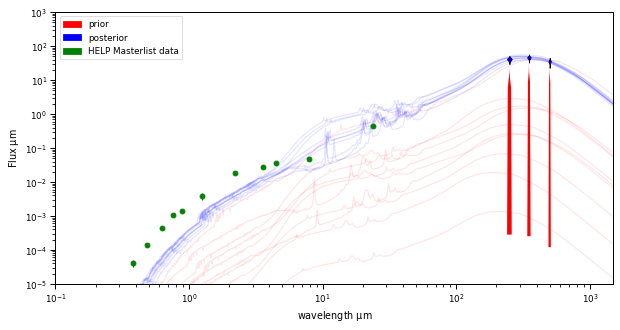

In [479]:
plt.figure(figsize=(10,5))
for i in range(0,nsamp):
    plt.loglog(w['wavelength_{}'.format(i+1)],f['Fnu_{}'.format(i+1)],'b',alpha=0.1)
    plt.loglog(w_prior['wavelength_{}'.format(i+1)],f_prior['Fnu_{}'.format(i+1)],'r',alpha=0.1)


    plt.xlim(0.1,1.5E3)
v=plt.violinplot(src_f[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('black')
        pc.set_alpha(1.0)
v=plt.violinplot(src_f_prior[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('red')
        pc.set_alpha(1.0)
plt.ylim(1E-5,1E3)
w_ind=wavelength<100
plt.errorbar(wavelength[w_ind],flux[w_ind],yerr=flux_error.reshape(-1)[w_ind],fmt='go',label='HELP masterlist')
plt.xlabel('wavelength $\mathrm{\mu m}$')
plt.ylabel('Flux $\mathrm{\mu m}$')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
green_patch = mpatches.Circle(0,color='green')

plt.legend([red_patch,blue_patch,green_patch],['prior','posterior','HELP Masterlist data'])

In [480]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [481]:
obs=Table.read('/Volumes/pdh_storage/cigale/fit_all_ESBs/observations.fits')
results=Table.read('/Volumes/pdh_storage/cigale/fit_all_ESBs/results.fits')

In [482]:
sed_plot = Table.read('/Volumes/pdh_storage/cigale/fit_all_ESBs/{}_best_model.fits'.format(prior_list['help_id'][ind][0]))

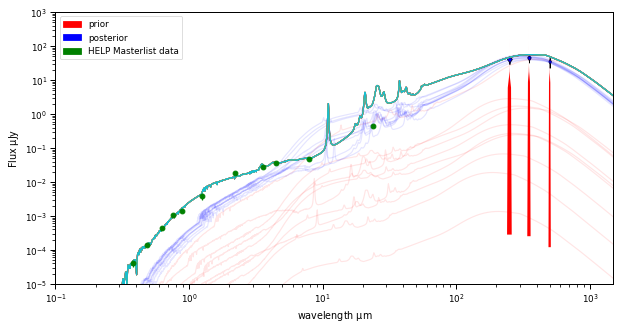

In [483]:
plt.figure(figsize=(10,5))
for i in range(0,nsamp):
    plt.loglog(w['wavelength_{}'.format(i+1)],f['Fnu_{}'.format(i+1)],'b',alpha=0.1)
    plt.loglog(w_prior['wavelength_{}'.format(i+1)],f_prior['Fnu_{}'.format(i+1)],'r',alpha=0.1)
    plt.loglog(sed_plot['wavelength']/1E3,sed_plot['Fnu'])


    plt.xlim(0.1,1.5E3)
v=plt.violinplot(src_f[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('black')
        pc.set_alpha(1.0)
v=plt.violinplot(src_f_prior[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('red')
        pc.set_alpha(1.0)
plt.ylim(1E-5,1E3)
w_ind=wavelength<100
plt.errorbar(wavelength[w_ind],flux[w_ind],yerr=flux_error.reshape(-1)[w_ind],fmt='go',label='HELP masterlist')
plt.xlabel('wavelength $\mathrm{\mu m}$')
plt.ylabel('Flux $\mathrm{\mu Jy}$')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
green_patch = mpatches.Circle(0,color='green')

plt.legend([red_patch,blue_patch,green_patch],['prior','posterior','HELP Masterlist data'])


In [484]:
10.0**esb['SFR log(M\xa0sol. yr−1)'][source[0]]

9772.372209558112

In [485]:
esb[source[0]]


RA,Dec,i,S 24 (μJy),S 250 (mJy),S 350 (mJy),S 500 (mJy),Z phot,Type,Chi,n bands,Z subm,Z comb,M * log(M sol.),SFR log(M sol. yr−1),field,help_id,status
float64,float64,str9,float64,float64,float64,float64,float64,str9,float64,int64,float64,float64,float64,float64,str13,str30,str50
160.50839,58.67179,23.49,904.6,95.7,79.5,60.5,3.81,Sab,4.1,6,2.86,3.07,12.02,3.99,Lockman-SWIRE,------------------------------,--------------------------------------------------


In [486]:
results[results['id']==prior_list['help_id'][ind]]

id,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.irac_i1,bayes.irac_i1_err,bayes.irac_i2,bayes.irac_i2_err,bayes.irac_i3,bayes.irac_i3_err,bayes.irac_i4,bayes.irac_i4_err,bayes.megacam_g,bayes.megacam_g_err,bayes.megacam_i,bayes.megacam_i_err,bayes.megacam_r,bayes.megacam_r_err,bayes.megacam_u,bayes.megacam_u_err,bayes.megacam_y,bayes.megacam_y_err,bayes.megacam_z,bayes.megacam_z_err,bayes.omegacam_g,bayes.omegacam_g_err,bayes.omegacam_i,bayes.omegacam_i_err,bayes.omegacam_r,bayes.omegacam_r_err,bayes.omegacam_u,bayes.omegacam_u_err,bayes.omegacam_z,bayes.omegacam_z_err,best.chi_square,best.reduced_chi_square,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.tau,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.dust.alpha,best.dust.gamma,best.dust.qpah,best.dust.umean,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.agn.agn_luminosity,best.agn.luminosity,best.agn.scatt_luminosity,best.agn.therm_luminosity,best.dust.luminosity,best.dust.mass,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.omegacam_u,best.megacam_u,best.omegacam_g,best.megacam_g,best.megacam_r,best.omegacam_r,best.megacam_i,best.omegacam_i,best.megacam_y,best.megacam_z,best.omegacam_z,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4
,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,,,deg,deg,,,mag,,mag,mag,mag,,,,,,,,,Myr,,,,,Myr,,,Myr,Myr,m,,W,W,W,W,W,kg,,solMass / yr,solMass / yr,solMass / yr,W,W,W,W,W,W,solMass,solMass,solMass,solMass,solMass,solMass,ph / s,ph / s,ph / s,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J104201.994+584018.387,3978.9185867660585,2022.1312981635383,1160.7208610195055,529.9377060988776,3979.663226029783,2023.9936752316714,0.028868880100287153,0.001861311146324843,0.036886370534476395,0.002291887369986528,0.045740507741373324,0.004043924439740032,0.04678304107484672,0.003731139805462192,0.0001541574082437502,1.2603582411746693e-05,0.0008450956212034213,6.579665694938228e-05,0.0004226582570655508,2.3109724670853302e-05,3.707952282159332e-05,3.3157628346897526e-06,0.0008973119517481388,7.788057000038627e-05,0.001

In [487]:
10.0**data.posterior['sfr'][:,:,np.argmin(separation)].median()

<xarray.DataArray 'sfr' ()>
array(972.79723477)
Coordinates:
    src      int64 99

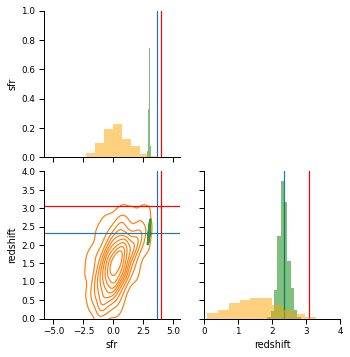

In [488]:
df=data.posterior[['sfr','redshift']].to_dataframe()
df_prior=data.prior[['sfr','redshift']].to_dataframe()

g=sns.PairGrid(df.stack()[:,:,np.argmin(separation)].unstack())
g.map_lower(sns.kdeplot)
g.map_diag(plt.hist,alpha=0.5,color='Green')
g.axes[0,0].axvline(x=np.log10(results[results['id']==prior_list['help_id'][ind]]['bayes.sfh.sfr']))
g.axes[1,0].axvline(x=np.log10(results[results['id']==prior_list['help_id'][ind]]['bayes.sfh.sfr']))
g.axes[1,0].axhline(y=results[results['id']==prior_list['help_id'][ind]]['best.universe.redshift'])

g.axes[1,1].axvline(x=results[results['id']==prior_list['help_id'][ind]]['best.universe.redshift'])
g.data=df_prior.stack()[:,:,np.argmin(separation)].unstack()
g.map_lower(sns.kdeplot)
g.map_diag(plt.hist,alpha=0.5,color='Orange')
g.data=df.stack()[:,:,np.argmin(separation)].unstack()
g.map_lower(sns.kdeplot)
g.axes[1,0].set_ylim(0,4)
g.axes[1,1].set_xlim(0,4)

g.axes[1,0].axhline(esb['Z\xa0comb'][source[0]],color='red')
g.axes[1,0].axvline(esb['SFR log(M\xa0sol. yr−1)'][source[0]],color='red')
g.axes[1,1].axvline(x=esb['Z\xa0comb'][source[0]],color='red')
g.axes[0,0].axvline(esb['SFR log(M\xa0sol. yr−1)'][source[0]],color='red')
g.axes[0,1].set_axis_off()

Things to do:
    Try new redshift!!
    
It would appear the best cigale fit is fixed to best redshift, but what happens if I take redshift of the xid+ fit?

XID+ prefers higher redshift and lower SFR to extreme SB. Note prior makes it almost impossible to get Michael's answer. 

In [51]:
import pandas as pd
pd.DataFrame()
sns.PairGrid()

TypeError: __init__() missing 1 required positional argument: 'data'

In [69]:
esb['SFR log(M\xa0sol. yr−1)'][source[0]]

RA,Dec,i,S 24 (μJy),S 250 (mJy),S 350 (mJy),S 500 (mJy),Z phot,Type,Chi,n bands,Z subm,Z comb,M * log(M sol.),SFR log(M sol. yr−1),field,help_id,status
float64,float64,str9,float64,float64,float64,float64,float64,str9,float64,int64,float64,float64,float64,float64,str13,str30,str50
160.50839,58.67179,23.49,904.6,95.7,79.5,60.5,3.81,Sab,4.1,6,2.86,3.07,12.02,3.99,Lockman-SWIRE,------------------------------,--------------------------------------------------


In [132]:
np.median(src_f[:,np.argmin(separation),:],axis=0)

array([41.296074, 46.0759  , 35.651485], dtype=float32)

In [85]:
data.prior['redshift'][:,:,np.argmin(separation)].median()

<xarray.DataArray 'redshift' ()>
array(1.5370045, dtype=float32)
Coordinates:
    src      int64 99

In [151]:
ls_tables=prior_list[ind]
cols_object=[c for c in ls_tables.columns if ls_tables[c].dtype =='O']
for c in cols_object:
    ls_tables[c]=ls_tables[c].astype(str)

In [153]:
ls_tables['f_spire_250']

18010.602


In [154]:
cols_keep=['help_id','ra','dec','redshift']+[c for c in ls_tables.colnames if 'megacam' in c]+[c for c in ls_tables.colnames if 'irac' in c]+[c for c in ls_tables.colnames if 'mips' in c]+[c for c in ls_tables.colnames if 'spire' in c]

In [157]:
ls_tables[cols_keep]

help_id,ra,dec,redshift,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_megacam_i,ferr_megacam_i,f_ap_megacam_i,ferr_ap_megacam_i,m_megacam_i,merr_megacam_i,m_ap_megacam_i,merr_ap_megacam_i,flag_megacam_i,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_megacam_y,ferr_megacam_y,f_ap_megacam_y,ferr_ap_megacam_y,m_megacam_y,merr_megacam_y,m_ap_megacam_y,merr_ap_megacam_y,flag_megacam_y,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_omegacam_g,ferr_omegacam_g,f_ap_omegacam_g,ferr_ap_omegacam_g,m_omegacam_g,merr_omegacam_g,m_ap_omegacam_g,merr_ap_omegacam_g,flag_omegacam_g,f_omegacam_i,ferr_omegacam_i,f_ap_omegacam_i,ferr_ap_omegacam_i,m_omegacam_i,merr_omegacam_i,m_ap_omegacam_i,merr_ap_omegacam_i,flag_omegacam_i,f_omegacam_r,ferr_omegacam_r,f_ap_omegacam_r,ferr_ap_omegacam_r,m_omegacam_r,merr_omegacam_r,m_ap_omegacam_r,merr_ap_omegacam_r,flag_omegacam_r,f_omegacam_u,ferr_omegacam_u,f_ap_omegacam_u,ferr_ap_omegacam_u,m_omegacam_u,merr_omegacam_u,m_ap_omegacam_u,merr_ap_omegacam_u,flag_omegacam_u,f_omegacam_z,ferr_omegacam_z,f_ap_omegacam_z,ferr_ap_omegacam_z,m_omegacam_z,merr_omegacam_z,m_ap_omegacam_z,merr_ap_omegacam_z,flag_omegacam_z,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500
str27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,int64,int64,float64,float64,int64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,int64,int64,int64,int64,int64,int64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,str5,float64,float64,str5,float64,float64,str5
HELP_J104201.994+584018.387,160.508307760025,58.6717742157497,1.5262,0.13638798892498,0.00534687424078584,0.1722559,0.0064295973,26.0630588531494,0.0425645634531975,25.809565,0.04052602,False,1.0827299,0.065295205,--,--,23.8137,0.0654765,--,--,False,0.450949192047119,0.00649893470108509,0.5393902,0.007878817,24.7646808624268,0.0156472809612751,24.570242,0.015859235,False,0.041311525,0.010343166,0.047589142,0.012394148,27.359821,0.27183577,27.20623,0.28276986,False,--,--,--,--,--,--,--,--,False,1.4262158870697,0.03220584243536,1.7002232,0.038417965,23.5145359039307,0.0245173592120409,23.323734,0.024533117,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,28.1582488902

In [156]:
from herschelhelp.external import convert_table_for_cigale
new_table=convert_table_for_cigale(ls_tables[cols_keep])

TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''

if CIGALE is showing that it needs extra parameters, then I need to fit them. If SFR is too constrained, what else can I fit

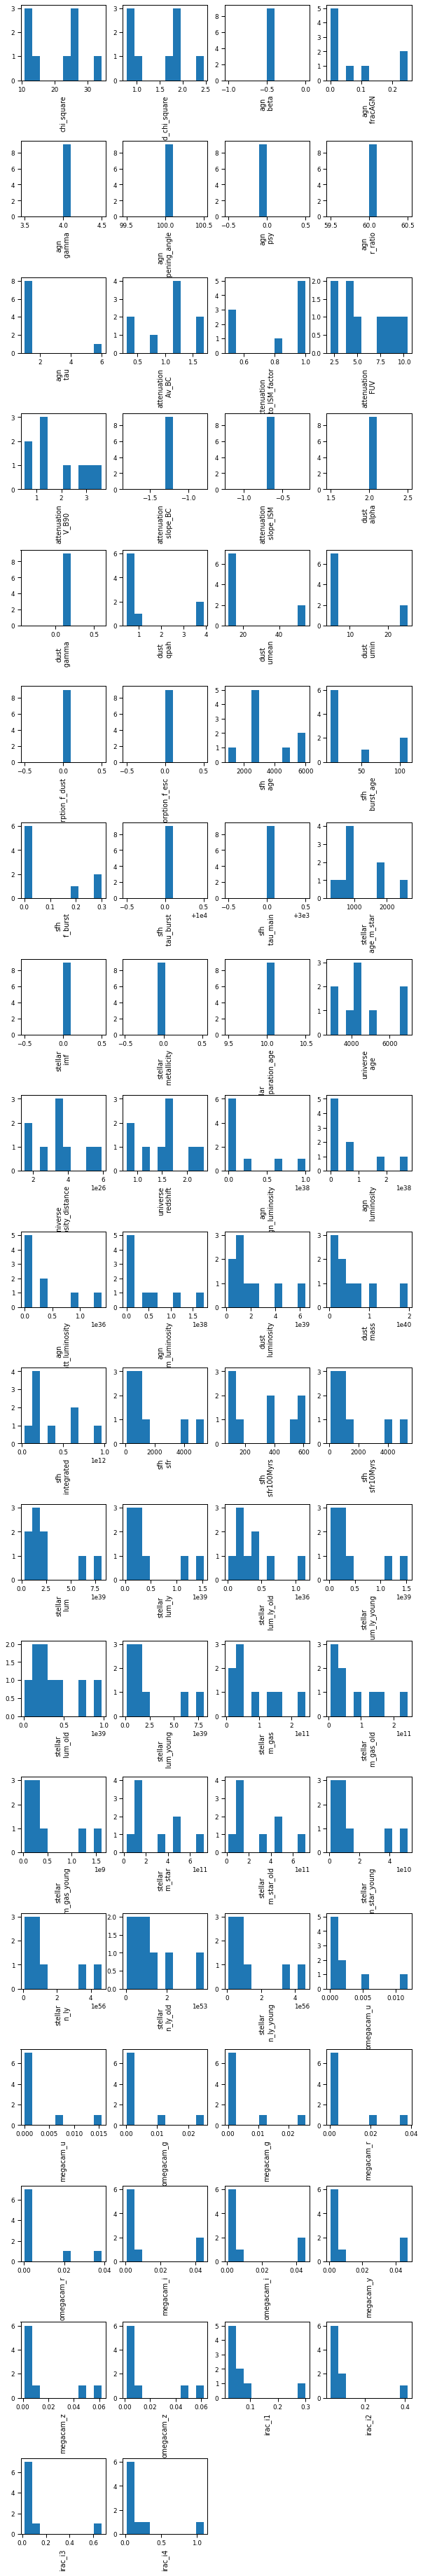

In [493]:
plt.figure(figsize=(10,70))
cols_plot=[c for c in results.colnames if 'best' in c]
for i in range(0,len(cols_plot)):
    plt.subplot(20,np.ceil(len(cols_plot)/20.0).astype(int),i+1)
    plt.hist(results[cols_plot[i]],bins=10);
    label='\n '.join([ i for i  in cols_plot[i].split('best.')[1].split('.')])
    plt.xlabel(label,rotation=90)
    #line=[c for c in tmp_fit.colnames if cols_plot[i].split('best.')[1] in c]
    #if len(line)>0:
        #plt.axvline(x=tmp_fit[line[0]][0],color='black')
    
plt.subplots_adjust(hspace=0.8)

In [492]:
results

id,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.irac_i1,bayes.irac_i1_err,bayes.irac_i2,bayes.irac_i2_err,bayes.irac_i3,bayes.irac_i3_err,bayes.irac_i4,bayes.irac_i4_err,bayes.megacam_g,bayes.megacam_g_err,bayes.megacam_i,bayes.megacam_i_err,bayes.megacam_r,bayes.megacam_r_err,bayes.megacam_u,bayes.megacam_u_err,bayes.megacam_y,bayes.megacam_y_err,bayes.megacam_z,bayes.megacam_z_err,bayes.omegacam_g,bayes.omegacam_g_err,bayes.omegacam_i,bayes.omegacam_i_err,bayes.omegacam_r,bayes.omegacam_r_err,bayes.omegacam_u,bayes.omegacam_u_err,bayes.omegacam_z,bayes.omegacam_z_err,best.chi_square,best.reduced_chi_square,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.tau,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.dust.alpha,best.dust.gamma,best.dust.qpah,best.dust.umean,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.agn.agn_luminosity,best.agn.luminosity,best.agn.scatt_luminosity,best.agn.therm_luminosity,best.dust.luminosity,best.dust.mass,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.omegacam_u,best.megacam_u,best.omegacam_g,best.megacam_g,best.megacam_r,best.omegacam_r,best.megacam_i,best.omegacam_i,best.megacam_y,best.megacam_z,best.omegacam_z,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4
,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,,,deg,deg,,,mag,,mag,mag,mag,,,,,,,,,Myr,,,,,Myr,,,Myr,Myr,m,,W,W,W,W,W,kg,,solMass / yr,solMass / yr,solMass / yr,W,W,W,W,W,W,solMass,solMass,solMass,solMass,solMass,solMass,ph / s,ph / s,ph / s,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J104201.994+584018.387,3978.9185867660585,2022.1312981635383,1160.7208610195055,529.9377060988776,3979.663226029783,2023.9936752316714,0.028868880100287153,0.001861311146324843,0.036886370534476395,0.002291887369986528,0.045740507741373324,0.004043924439740032,0.04678304107484672,0.003731139805462192,0.0001541574082437502,1.2603582411746693e-05,0.0008450956212034213,6.579665694938228e-05,0.0004226582570655508,2.3109724670853302e-05,3.707952282159332e-05,3.3157628346897526e-06,0.0008973119517481388,7.788057000038627e-05,0.001